In [37]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

# Custom modules and functions
import capstone.portfolio.optimize as opt
from capstone.portfolio.prune import prune_recommended_portfolios
from capstone.model_selection import overunder_error, ts_cross_val_score, arimax_cross_val_score
from capstone.utils import read_file, get_sectors, load_models, set_plot_style

# SARIMAX model from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

# PCA & Pipeline
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Progress bar for loops
from tqdm.auto import tqdm

set_plot_style()

In [2]:
# Load files
df = read_file("master_df", index_col=0)
snp_log_returns = read_file("snp_log_returns", index_col=0)
stocks_by_sector = read_file("stocks_by_sector", index_col=0)
sectors = get_sectors()

In [105]:
# Separate the combined dataframe into targets (sector average returns) and features
y_all = df[sectors]
X_all = df[df.columns[~df.columns.isin(sectors)]]

X_all.shape, y_all.shape

((4230, 109), (4230, 11))

In [7]:
# Load models
models = load_models()
models.keys()

dict_keys(['ElasticNet', 'SVR', 'RandomForest', 'GradientBoost', 'XGBoost'])

In [15]:
# Define number of trading days in a year
trading_days = 252

# Set forecast window
forecast = int(trading_days / 2)

# Separate features and targets
X_recent = X_all[-trading_days:]
y_all_recent = y_all[-trading_days:]

X_train_recent = X_recent[:forecast]
y_all_train_recent = y_all_recent[-forecast:]

X_test_recent = X_recent[-forecast:]

In [40]:
# Initialize a pipeline for data preprocessing: Standardization followed by PCA
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=.8, random_state=42))

# Define ARIMAX model orders for ARIMA and seasonal components
order = (1, 0, 1)

# Initialize DataFrames to store mean over-under loss (OUL) and model predictions
mean_ouls = pd.DataFrame()
predictions = pd.DataFrame()

# Loop through each sector for analysis
for sector in tqdm(sectors):
    
    # Use the most recent data for training and testing
    X_train = X_train_recent
    y_train = y_all_train_recent[sector]
    X_test = X_test_recent

    # Loop through each machine learning model
    for name, model in models.items():
        
        # Compute mean OUL using time-series cross-validation
        mean_oul = np.mean(
            ts_cross_val_score(
                model,
                X_train,
                y_train,
                cv=2,
                scorer=overunder_error,
                overpred_penalty=2,
                underpred_penalty=0
            )
        )
        
        # Store the mean OUL for each model and sector
        mean_ouls.loc[name, sector] = mean_oul
        
        # Fit the model and make predictions
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        
        # Store the mean predicted value for each model and sector
        predictions.loc[name, sector] = np.mean(y_hat)

    # Apply PCA transformation to the training and testing feature sets
    X_train_pca = pca_pipe.fit_transform(X_train)
    X_test_pca = pca_pipe.transform(X_test)

    # Compute mean OUL for the ARIMAX model using time-series cross-validation
    arimax_mean_oul = np.mean(
        arimax_cross_val_score(
            X_train,
            y_train,
            order=order,
            pca=pca_pipe,
            cv=2,
            scorer=overunder_error,
            overpred_penalty=2,
            underpred_penalty=0
        )
    )
    
    # Fit the ARIMAX model and make forecasts
    arimax = SARIMAX(endog=y_train, exog=X_train_pca, order=order).fit()
    forecast_result = arimax.get_forecast(steps=(len(X_test_pca)), exog=X_test_pca)
    arimax_y_hat = forecast_result.predicted_mean
    
    # Store the mean OUL and predicted values for ARIMAX model
    mean_ouls.loc["ARIMAX", sector] = arimax_mean_oul
    predictions.loc["ARIMAX", sector] = np.mean(arimax_y_hat)

  0%|          | 0/11 [00:00<?, ?it/s]

In [44]:
# Compute the mean Over-Under Loss (OUL) for each model across all sectors
# This is done by taking the mean of OUL values along the columns (axis=1)
# This gives a summary metric of how each model performs on average across different sectors
model_ouls = mean_ouls.mean(axis=1)
model_ouls

ElasticNet       0.073553
SVR              0.100738
RandomForest     0.077985
GradientBoost    0.079905
XGBoost          0.092130
ARIMAX           0.094213
dtype: float64

In [103]:
# Identify the sectors where each model has its highest mean predicted value
# For each row (model) in the 'predictions' DataFrame, find the column (sector) that has the maximum value
# This essentially selects the best-performing sector for each model based on their predictions
selected_sectors = predictions.idxmax(axis=1)
selected_sectors

ElasticNet       INFORMATION_TECHNOLOGY
SVR              CONSUMER_DISCRETIONARY
RandomForest     INFORMATION_TECHNOLOGY
GradientBoost                    ENERGY
XGBoost          INFORMATION_TECHNOLOGY
ARIMAX           INFORMATION_TECHNOLOGY
dtype: object

In [46]:
# Retrieve the best model
best_model = model_ouls.idxmin()
best_model

'ElasticNet'

In [47]:
# Retrieve the sector selected by the best model
selected_sector = selected_sectors.loc[best_model]
selected_sector

'INFORMATION_TECHNOLOGY'

In [63]:
# Retrieve available stocks in the selected sector
selected_stocks = stocks_by_sector[stocks_by_sector["GICS Sector"] == selected_sector]
selected_stocks = selected_stocks["Symbol"].to_list()
selected_stocks = [s for s in selected_stocks if s in snp_log_returns.columns]

print(f"Selected stocks: {', '.join(selected_stocks[:3])},\
...,{', '.join(selected_stocks[-3:])}.")

Selected stocks: ACN, ADBE, AKAM,...,VRSN, WDC, ZBRA.


In [96]:
# Calculate the number of stocks in the selected list
n_stocks = len(selected_stocks)

# Initialize portfolio weights: equal weighting for all selected stocks
initial_weights = np.array([1/n_stocks] * n_stocks)

# Extract recent log returns based on the forecast horizon
recent_returns = snp_log_returns[-forecast:]

# Filter the recent returns to only include the selected stocks
constituent_returns = recent_returns[selected_stocks]

# Optimize portfolio to maximize the Sharpe ratio
ms_allocations = opt.max_sharpe_opt(initial_weights, constituent_returns)[0]

# Optimize portfolio to minimize variance
mv_allocations = opt.min_var_opt(initial_weights, constituent_returns)[0]

# Optimize portfolio using risk parity strategy
rp_allocations = opt.risk_parity_opt(initial_weights, constituent_returns)[0]

# Convert allocations into Pandas Series for easier handling, indexed by stock names
ms_portfolio = pd.Series(ms_allocations, index=selected_stocks)
mv_portfolio = pd.Series(mv_allocations, index=selected_stocks)
rp_portfolio = pd.Series(rp_allocations, index=selected_stocks)

# Prune portfolios to remove or adjust undesirable allocations
ms_portfolio, mv_portfolio, rp_portfolio = prune_recommended_portfolios(
    ms_portfolio, mv_portfolio, rp_portfolio
)


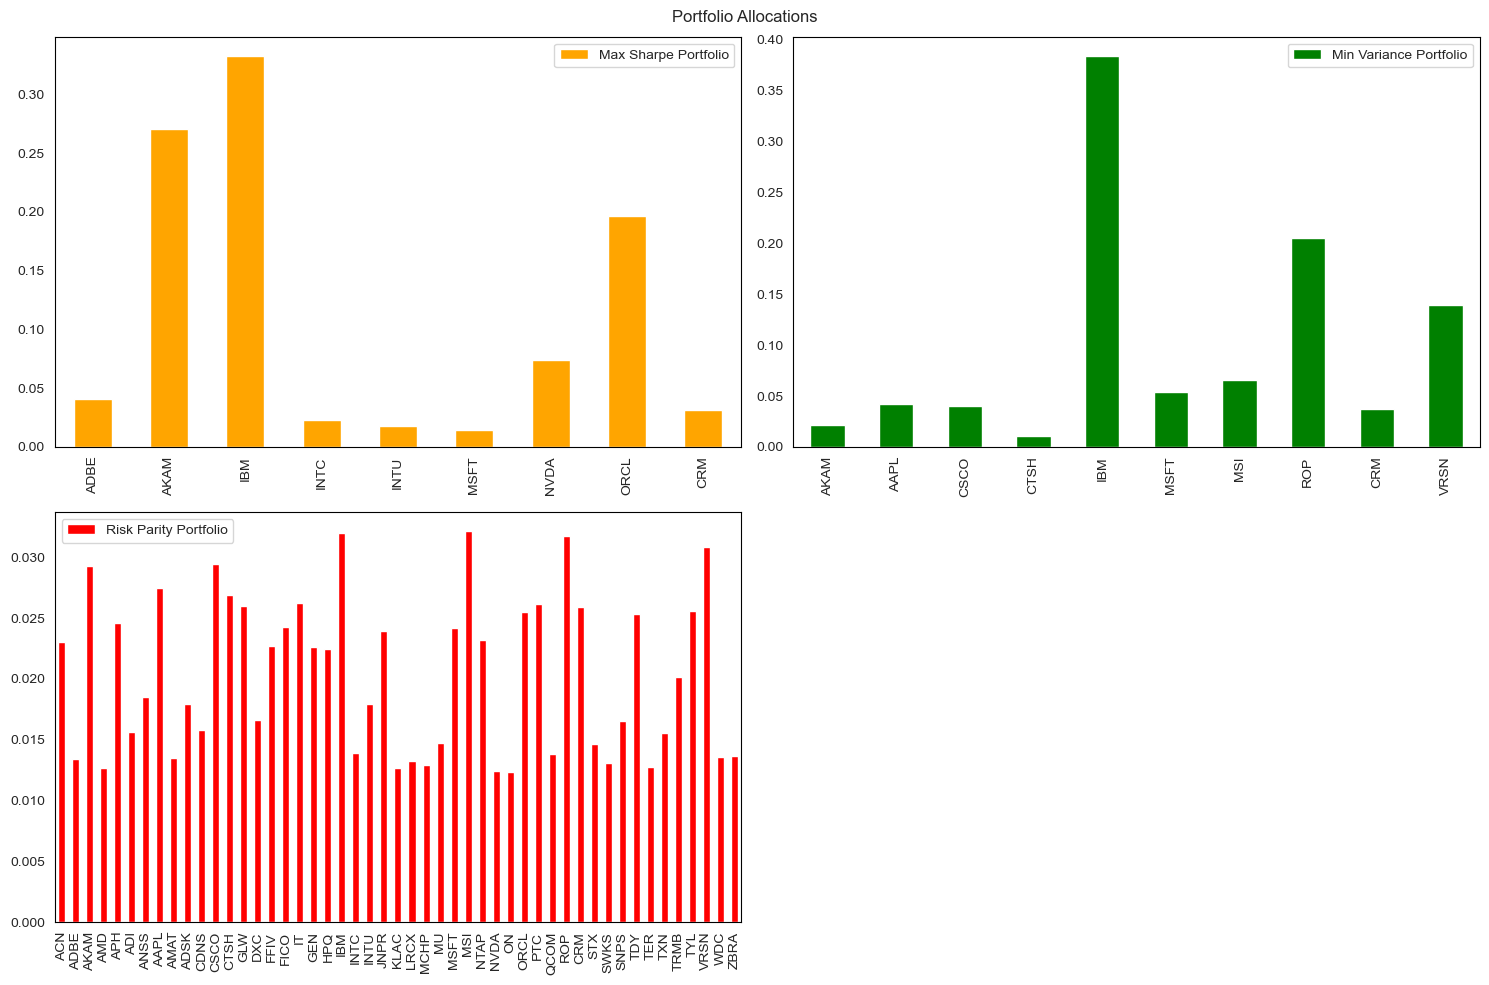

In [102]:
# Plot portfolio allocations
portfolios = [
    ms_portfolio,
    mv_portfolio,
    rp_portfolio,
]

colors = ["orange", "green", "red"]

names = [
    "Max Sharpe Portfolio", 
    "Min Variance Portfolio",
    "Risk Parity Portfolio"
]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Portfolio Allocations")
axes = axes.flatten()

for i, portfolio in enumerate(portfolios):
    portfolio.plot.bar(ax=axes[i], color=colors[i], grid=False)
    axes[i].legend([names[i]])

axes[-1].axis("off")
plt.tight_layout()